# GesBerry Machine Learning


This Jupyter notebook introduces the Signal Processing steps of the gesture recognition software. This notebook can be run independently from the Raspberry Pi. No further installations are necessary. Important to mention is that this is still in a prototypic state. The system works in its current state, but there are still many things that can be improved and this an ongoing project. If you have any suggestions or critique, please write me an email to maximilian.lell@gmail.com

The data to evaluate the procedure is also provided: See folder data in the repository.

This notebook is structured from a high-level approach to the low-level details. 

## Signalflow
The following flowchart shows the signal flow for this notebook:

<br/>

<img src="img/flowchart_ATest.png" width="600">

<br/>

The following procedure is executed (steps have the same numbers as the grey boxes above):
1. Get labeled dataset and split it into training and test set
2. preprocess and learn from train data; afterwards put a decision boundary function out. The decision boundary function contains the knowledge of the classifier on how to relate the data to the gestures
3. preprocess and classify the data. The preprocessing is the same as it is applied in the learning step. The labels are excluded and the classifier identifies the labels of the gestures
4. Evaluate the classification results in 3 experiments:
    - Confusion matrix
    - Accuracy score
    - k-fold crossvalidation score

In [1]:
# imports
import numpy as np # -------------------------------------- vers. numpy:  1.14.0
import pandas as pd # ------------------------------------- vers. pandas: 0.22.0

# 1. Dataset Structure
import sys, os
from sklearn.model_selection import train_test_split # ---- vers. scikit-learn: 0.19.1

# 2. Preprocessing
from scipy import signal # -------------------------------- vers. scipy: 1.0.0
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

# 3. Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# 4. Evaluation
import matplotlib.pyplot as plt # -------------------------- vers. matplotlib: 2.1.2
%matplotlib inline
import seaborn as sn # ------------------------------------- vers. seaborn: 0.8.1
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## 1. Dataset structure

#### functions

In [2]:
def get_datasets(path):
    '''(str) --> np.array[130,980], np.array[130,1]
    
    Reads in the *.csv files from the dataset at a given path-location and returns their values as
    numpy arrays.
    
    args:
        * path (str): variable that contains the complete path to the dataset's directory
    
    returns:
        * X_raw (np.array[130,980]): time progression signals stacked in a matrix.
        * labels (y) from a given path out of a *.csv-file
    
    '''
    X_raw = pd.read_csv(path + '/' + 'raw_data.csv', index_col=0).values
    y     = pd.read_csv(path + '/' + 'label.csv'   , header=None).values.ravel()
    
    return X_raw,y

----

In [3]:
# selectable datasets:
# User 1: 'User_1_1_011017', 'User_1_2_011017', 'User_1_3_121017' 
# User 2: 'User_2_1_071017' 
# User 3: 'User_3_1_131017', 'User_3_2_131017'
# User 4: 'User_4_1_150917'

path = os.getcwd() + '/data/' + 'User_1_3_121017' # -- change User_x_x_xxxxxx for different dataset
X_raw,y = get_datasets(path) # ----------------------- Function loads the data and the labels
frame_size = 140 # ----------------------------------- 1.4 seconds recording window

In [4]:
print(X_raw.shape)  # X --> raw dataset
print(y.shape)      # y --> labels

(130, 980)
(130,)


The __raw dataset X__ is saved in a (130 ∗ 980) matrix, containing the sensor readings.

- _13 gestures ∗ 10 executions = 130 rows_

- _1.4 seconds ∗ 100 Hz sampling frequency ∗ 7 sensor axes = 980 columns_

The 13 gestures are executed 10 times. Each gesture recording
takes 1.4 seconds. The raw data sensor readings consist of 7 time progression signals (ax,ay,az,qw,qx,qy,qz), aligned into a single vector: 
- ax = Linear acceleration in x
- ay = Linear acceleration in y
- az = Linear acceleration in z
- qw = Angular acceleration in quaternions
- qx = Angular acceleration in quaternions
- qy = Angular acceleration in quaternions
- qz = Angular acceleration in quaternions

From index 0 to 140 the vector contains the readings from the x-
acceleration, index 140 to 280 show the acceleration readings of the y-axes, and so forth.
The reason for recording 1.4 seconds is that every gesture execution needs
to fit into that time window. The longest gesture performance took approximately 1.4
seconds. Incomplete gestures lead to biased predictions.

The __labels__ contain the labels of the concerning gestures as a string

In [5]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.3) 
# split dataset into random Train and Test Data

print(X_train_raw.shape)
print(X_test_raw.shape)
print(y_train.shape)
print(y_test.shape)

(91, 980)
(39, 980)
(91,)
(39,)


## 2. Preprocessing

This section contains the complete feature construction process. The way to preprocess the raw data is adapted from:
- Using Machine Learning for Real-time Activity Recognition and Estimation of Energy Expenditure - Tapia, Emmanuel <br/>(Link: http://hdl.handle.net/1721.1/44913)
- Accelerometer Gesture Recognition - Xie M, Pan D <br/>(Link: http://cs229.stanford.edu/proj2014/Michael%20Xie,%20David%20Pan,%20Accelerometer%20Gesture%20Recognition.pdf)

The following table shows the features that are calculated:

<br/>
<img src="img/feature_table1.png" width="600">
<img src="img/feature_table2.png" width="600">

<br/>
The indicators of different features (e.g. ___1. Measures of bodyposture___) are also used in the function section below. Besides the features that are listed in the table also the fouriersignal for each axis is calculated and appended at the end of the feature vector

#### functions

In [40]:
#################### main function #####################################

def preprocess_raw_data(X_raw, frame_size):
    """(np.array, int) --> np.array
    
    Function that transforms the raw time progression signal into feature vectors. Afterwards
    the feature vector is normalized.
    (Dimensions of matrizes depend from the frame_size - the dimensions
    that are listed here refer to a frame_size of 140! Same comes for all
    listed subfunctions)
    
    args:
        * X_raw (np.array[130,980]): raw data - can be a single vector or a matrix
        * frame_size (int): recording window size
    
    Returns:
        * Preprocessed dataset (X) - vector or matrix
        * Test efficiency of features to streamline code
            - Only FFT-Features
            - Only Tapia features
            - Selected Tapia Features
            
    
        
    """
    norm = Normalizer()
    X = np.array([])
    for row in range(X_raw.shape[0]): 
        
        # in case only one vector (X_raw) is provided: Output normalized featurevector
        # in case X_raw represents a matrix: Split matrix up into vectors, calculate feature
        # vectors, stack them and output the transformed dataset X
        
        # split up matrix into vector and process single vectors
        x_raw = X_raw[row, :]
        
        # create feature vector from raw data vector
        feature_vector = create_feature_vector(x_raw, frame_size) 
    
        # normalize featurevector
        feature_vector = norm.fit_transform(feature_vector) 
        
        # in case only one vector (X_raw) is provided: Output featurevector
        if X.shape[0] == 0:
            X = feature_vector
        
        # in case a Matrix (X_raw) is provided: Stack to matrix and output matrix
        else:
            X = np.concatenate((X,feature_vector), axis=0) # --------- 

    return X

########################################################################

def create_feature_vector(y, frame_size, f_abt = 100):
    """(np.array[1,980], int, [int] --> np.array[1,259]
    
    Transforms the raw time progression signal vector into feature vector.
    
    args:
        * y (np.array[1,980]): raw time progression signal vector
        * frame_size (int):    duration of recording window in 100ms 
                               (e.g.: frame_size = 140 -> record time window: 1.4 sec)
    
    returns:
        * features (np.array[1,259]): feature vector
        
    TODO:
        * standarize the choice of variables in functions: 
          create_feature_vector: y = x_raw: confusing description.
        * rework comments of helper functions
    
    """

        
    # reshape vector back to matrix representation
    y = y.reshape(frame_size,7)
    
    ############################ Tapia Features #########################
    ###################### 1. Measures of body posture #################
    # LowPass Filter 1Hz
    y_lowpass_filter = lowpass_filter(y, 1, f_abt)

    # DCMean
    acl_DCMean_x    = np.mean(y_lowpass_filter[:,0]) #ax
    acl_DCMean_y    = np.mean(y_lowpass_filter[:,1]) #ay
    acl_DCMean_z    = np.mean(y_lowpass_filter[:,2]) #az
    gy_DCMean_qs    = np.mean(y_lowpass_filter[:,3]) #qs
    gy_DCMean_qx    = np.mean(y_lowpass_filter[:,4]) #qx
    gy_DCMean_qy    = np.mean(y_lowpass_filter[:,5]) #qy
    gy_DCMean_qz    = np.mean(y_lowpass_filter[:,6]) #qz

    # DCTotalMean
    acl_DCTotalMean = np.sum(acl_DCMean_x + acl_DCMean_y + 
                             acl_DCMean_z)
    gy_DCTotalMean  = np.sum(gy_DCMean_qs + gy_DCMean_qx + 
                             gy_DCMean_qy + gy_DCMean_qz)

    # DCArea
    acl_DCArea = np.sum(y[:,0] + y[:,1] + y[:,2])
    gy_DCArea  = np.sum(y[:,3] + y[:,4] + y[:,5] + y[:,6])

    # DCPostureDist
    acl_DC_PostureDist_XZ       = acl_DCMean_x - acl_DCMean_z #X-Z
    acl_DC_PostureDist_XY       = acl_DCMean_x - acl_DCMean_y #X-Y
    acl_DC_PostureDist_YZ       = acl_DCMean_y - acl_DCMean_z #Y-Z
    gy_DC_PostureDist_qsqx      = gy_DCMean_qs - gy_DCMean_qx #qs-qx
    gy_DC_PostureDist_qxqy      = gy_DCMean_qx - gy_DCMean_qy #qx-qy
    gy_DC_PostureDist_qyqz      = gy_DCMean_qy - gy_DCMean_qz #qy-qz
    gy_DC_PostureDist_qzqs      = gy_DCMean_qz - gy_DCMean_qs #qz-qs

    ################### 2. Measures of motion shape ##################

    # BandPass Filter 1Hz - 20Hz
    y_bandpass_filter = bandpass_filter(y, 0.1, 25, f_abt) 

    # ACAbsMean
    acl_ACAbsMean_x    = np.mean(np.abs(y_bandpass_filter[:,0])) #ax
    acl_ACAbsMean_y    = np.mean(np.abs(y_bandpass_filter[:,1])) #ay
    acl_ACAbsMean_z    = np.mean(np.abs(y_bandpass_filter[:,2])) #az
    gy_ACAbsMean_qs    = np.mean(np.abs(y_bandpass_filter[:,3])) #qs
    gy_ACAbsMean_qx    = np.mean(np.abs(y_bandpass_filter[:,4])) #qx
    gy_ACAbsMean_qy    = np.mean(np.abs(y_bandpass_filter[:,5])) #qy
    gy_ACAbsMean_qz    = np.mean(np.abs(y_bandpass_filter[:,6])) #qz

    # ACAbsArea
    acl_ACAbsArea = np.sum(np.abs(y_bandpass_filter[:,0]) + 
                           np.abs(y_bandpass_filter[:,1]) + 
                           np.abs(y_bandpass_filter[:,2]))
    gy_ACAbsArea  = np.sum(np.abs(y_bandpass_filter[:,3]) + 
                           np.abs(y_bandpass_filter[:,4]) + 
                           np.abs(y_bandpass_filter[:,5]) +
                           np.abs(y_bandpass_filter[:,6]))

    # ACSkew
    acl_ACSkew_x    = ACSkew(y_bandpass_filter[:,0])
    acl_ACSkew_y    = ACSkew(y_bandpass_filter[:,1])
    acl_ACSkew_z    = ACSkew(y_bandpass_filter[:,2])
    gy_ACSkew_qs    = ACSkew(y_bandpass_filter[:,3])
    gy_ACSkew_qx    = ACSkew(y_bandpass_filter[:,4])
    gy_ACSkew_qy    = ACSkew(y_bandpass_filter[:,5])
    gy_ACSkew_qz    = ACSkew(y_bandpass_filter[:,6])

    # ACKur
    acl_ACKur_x = ACKur(y_bandpass_filter[:,0])
    acl_ACKur_y = ACKur(y_bandpass_filter[:,1])
    acl_ACKur_z = ACKur(y_bandpass_filter[:,2])
    gy_ACKur_qs = ACKur(y_bandpass_filter[:,3])
    gy_ACKur_qx = ACKur(y_bandpass_filter[:,4])
    gy_ACKur_qy = ACKur(y_bandpass_filter[:,5])
    gy_ACKur_qz = ACKur(y_bandpass_filter[:,6])

    ################# 3. Measures of motion energy #################

    #ACVar
    acl_gy_ACVar = ACVar(y_bandpass_filter)
    acl_gy_ACAbsCV = ((np.sqrt(ACVar(y_bandpass_filter)))
                      /np.mean(y_bandpass_filter))*100
    
    # ACEnergy
    acl_ACEnergy, gy_ACEnergy = calc_signal_energy(y_bandpass_filter)

    # ACBandEnergy
    acl_ACBandEnergy, gy_ACBandEnergy = calc_signal_energy(
        bandpass_filter(y, 0.3, 3.5, f_abt)) 

    #ACLowEnergy
    acl_ACLowEnergy, gy_ACLowEnergy = calc_signal_energy(
        bandpass_filter(y, 0.0001, 0.71, f_abt))

    #ACModVigEnergy
    acl_ACModVigEnergy, gy_ACModVigEnergy = calc_signal_energy(
        bandpass_filter(y, 0.71, 10, f_abt)) 
    
    #ACGesSpec1Energy
    acl_ACGesSpec1Energy, gy_ACGesSpec1Energy = calc_signal_energy(
        bandpass_filter(y, 0.1, 15, f_abt)) 
    
    #ACGesSpec2Energy
    acl_ACGesSpec2Energy, gy_ACGesSpec2Energy = calc_signal_energy(
        bandpass_filter(y, 3, 20, f_abt)) 
    
    #ACGesSpec3Energy
    acl_ACGesSpec3Energy, gy_ACGesSpec3Energy = calc_signal_energy(
        bandpass_filter(y, 10, 25, f_abt)) 

    ################# Stack to vector ####################
    
    features = np.array([])
    features = np.append(features,
                         [acl_DCMean_x, acl_DCMean_y, acl_DCMean_z, 
                          gy_DCMean_qs, gy_DCMean_qx, gy_DCMean_qy, 
                          gy_DCMean_qz,
                          acl_DCTotalMean, gy_DCTotalMean, 
                          acl_DCArea, gy_DCArea,
                          acl_DC_PostureDist_XZ, acl_DC_PostureDist_XY, 
                          acl_DC_PostureDist_YZ,
                          gy_DC_PostureDist_qsqx, gy_DC_PostureDist_qxqy, 
                          gy_DC_PostureDist_qyqz, gy_DC_PostureDist_qzqs,
                          acl_ACAbsMean_x, acl_ACAbsMean_y, acl_ACAbsMean_z, 
                          gy_ACAbsMean_qs, gy_ACAbsMean_qx, gy_ACAbsMean_qy, 
                          gy_ACAbsMean_qz,
                          acl_ACAbsArea, gy_ACAbsArea,
                          acl_ACSkew_x, acl_ACSkew_y, acl_ACSkew_z, 
                          gy_ACSkew_qs, gy_ACSkew_qx, gy_ACSkew_qy, 
                          gy_ACSkew_qz,
                          acl_ACKur_x, acl_ACKur_y, acl_ACKur_z, 
                          gy_ACKur_qs, gy_ACKur_qx, gy_ACKur_qy, gy_ACKur_qz,
                          acl_ACEnergy, gy_ACEnergy, acl_ACBandEnergy, 
                          gy_ACBandEnergy,
                          acl_ACLowEnergy, gy_ACLowEnergy, 
                          acl_ACModVigEnergy, gy_ACModVigEnergy,
                          acl_ACGesSpec1Energy, gy_ACGesSpec1Energy,
                          acl_ACGesSpec2Energy, gy_ACGesSpec2Energy,
                          acl_ACGesSpec3Energy, gy_ACGesSpec3Energy])
    
    
    ########################### FFT - Features #############################
    ###################### calculate fouier spectrum #######################
    
    acl_gy_fourier_spectrum = fourier_spec_signal(y, frame_size)[:30,:].reshape(1,-1)
    features = np.append(features, acl_gy_fourier_spectrum)                    
    
    ######################### return feature vector ########################
    
    return features.reshape(1,-1)



    #################### filter helper functions #################

def bandpass_filter(y, f_cutoff_low, f_cutoff_high, f_abt):
    """
    Returns a bandpass filtered signal
    """
    nyq = 0.5 * f_abt
    low_cutoff = f_cutoff_low / nyq
    high_cutoff = f_cutoff_high / nyq
    
    bandpass_signal = np.zeros(y.shape)

    for i in range(y.shape[1]):
            b, a = signal.butter(5, [low_cutoff, high_cutoff] , 'bandpass') 
            # Bandpass
            bandpass_signal[:,i] = signal.filtfilt(b, a, y[:,i])
    
    return bandpass_signal

def lowpass_filter(y, f_cutoff, f_abt):
    """
    Returns a lowpass filtered signal
    """
    
    nyq = 0.5 * f_abt
    normal_cutoff = f_cutoff / nyq
    
    lowpass_signal = np.zeros(y.shape)
    for i in range(y.shape[1]):
        b, a = signal.butter(5, normal_cutoff , 'low') # Tiefpass
        lowpass_signal[:,i] = signal.filtfilt(b, a, y[:,i])
    
    return lowpass_signal


    ########### feature functions for calculation ###########


def ACSkew(x):
    '''(np.vector) --> float
    
    returns a measure of the peakedness of the accelerometer / 
    gyroscope signal over a given window
    '''
    n = len(x)
    
    sum_numerator   = np.sum (np.power ((x - np.mean(x)), 3))
    sum_denominator = np.sum (np.power ((x - np.mean(x)), 2))

    return (np.sqrt(n) * sum_numerator) / (np.power(sum_denominator, 3/2))

def ACKur(x):
    '''(np.vector) --> float
    
    returns a measure of the peakedness of the accelerometer / gyroscope 
    signal over a given window or a measure of its relative flatness 
    as compared to the normal distribution.
    '''
    n = len(x)
    
    sum_numerator   = np.sum (np.power ((x - np.mean(x)), 4))
    sum_denominator = np.sum (np.power ((x - np.mean(x)), 2))

    return (n * sum_numerator / (np.power(sum_denominator,2)))-3

def calc_signal_energy(y, N = 140):
    '''(np.array[140,7], [int]) --> np.array[30,7], np.array[40,7]
    
    returns the signal energy of the accelerometers and gyroscopes.
    '''
    
    yf = fft(y)
    half_abs_yf = 2/N*np.abs(yf[0:N//2,:])
    acl_energy = np.sum(half_abs_yf[:,0:3])
    gy_energy = np.sum(half_abs_yf[:,3:7])
    return acl_energy, gy_energy

def fourier_spec_axis(y):
    '''(np.array) -> np.array
    calculates the fft spectrum of the signal and returns it.
    '''
    N = len(y)
    yf = fft(y)
    half_abs_yf = 2/N*np.abs(yf[0:N//2])
    return half_abs_yf

def fourier_spec_signal(y, frame_size= 140):
    '''(np.array, int) --> np.array

    returns the standard scaled fourierspectrum (70,7) 
    of each vector (140,1) of the input signal matrix (140,7)
    '''
    
    fourier_spec = np.array([])
    for i in range(y.shape[1]):
        fourier_spec = np.append(fourier_spec, 
                                 fourier_spec_axis(y[:, i]))
    fourier_spec = fourier_spec.reshape(frame_size//2, 7)
    scaler = StandardScaler()
    fourier_spec = scaler.fit_transform(fourier_spec)
    return fourier_spec

def varianz(x):
    """(np.array) -> np.array [1, 5]
    
    seperates the signal into 4 parts, calculates the 
    variance of the concerning section and returns it 
    as a list
    """
    a = np.var(x)
    s = np.array([])
    
    one_fourth = (len(x)//4)
    
    for i in range(0,len(x), one_fourth):
        s = np.append(s, np.var(x[i:i+one_fourth]))
    s = np.append(s, a)
    return s


def ACVar(y):
    '''(np.array[140,7]) --> np.array
    
    returns the a modified signal's variance
    (see docstring of function varianz())
    '''
    a = np.array([])
    for i in range(y.shape[1]):
        a = np.append(a, varianz(y[:,i]))
    return a

---

In [41]:
X_train = preprocess_raw_data(X_train_raw, frame_size)
X_test = preprocess_raw_data(X_test_raw , frame_size)

## 3. Machine Learning

In this chapter first various classifiers are tested against each other. Their scores are evaluated with a 10 fold cross validation score. The best classifier will be selected and its hyperparameters are fine tuned.

#### functions

In [42]:
def cross_val(clf, X, y):
    '''(clf, np.array, np.array) --> None
    
    calculates and prints a 10 fold crossval score.
    
    args:
        * clf: trained classifer
    '''
    
    scores = cross_val_score(clf, X, y, cv = 10)
    print(clf.__class__.__name__, '--->',"Crossval score Accuracy:  %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
def train_clf_rf(X, y):
    '''(np.array(n,980), np.array(n,), int, str) --> None

    Trains a Random Forest Classifier on the preprocessed data
    and returns the decision boundary functions
    '''

    # define classifier
    clf = RandomForestClassifier(bootstrap = True, max_depth = 30, max_features = 4, n_estimators = 250)
    
    # train classifier
    clf.fit(X, y)

    return clf

---

In [44]:
X = preprocess_raw_data(X_raw, frame_size) # Preprocess entire Dataset for the 10 fold cross validation score.

# Classifier selection
classifiers = [
                KNeighborsClassifier(), # ------------------ K-Nearest Neighbour         
                SVC(), # ----------------------------------- Support Vector Machine                       
                NuSVC(), # --------------------------------- Support Vector Machine
                DecisionTreeClassifier(), # ---------------- Decision Tree Classifier
                RandomForestClassifier(), # ---------------- Random Forest Classifier
                AdaBoostClassifier(), # -------------------- AdaBoost Classifier
                GradientBoostingClassifier(), # ------------ GradientBoostingClassifier
                GaussianNB(), # ---------------------------- Gaussian Naive Bayes Classfier
                MLPClassifier(learning_rate_init=0.15)] # -- Neural Network

print('-'*100)

for clf in classifiers:
    
    cross_val(clf, X, y) # calculate a 10-fold-cross-validation score and print it.
    print('-'*100)

----------------------------------------------------------------------------------------------------
KNeighborsClassifier ---> Crossval score Accuracy:  0.45 (+/- 0.29)
----------------------------------------------------------------------------------------------------
SVC ---> Crossval score Accuracy:  0.43 (+/- 0.20)
----------------------------------------------------------------------------------------------------
NuSVC ---> Crossval score Accuracy:  0.34 (+/- 0.23)
----------------------------------------------------------------------------------------------------
DecisionTreeClassifier ---> Crossval score Accuracy:  0.78 (+/- 0.20)
----------------------------------------------------------------------------------------------------
RandomForestClassifier ---> Crossval score Accuracy:  0.95 (+/- 0.10)
----------------------------------------------------------------------------------------------------
AdaBoostClassifier ---> Crossval score Accuracy:  0.25 (+/- 0.20)
----------------

The Random Forest Classifier works the best out of the box --> Algorithm of choice: Random Forest Classifier. The best hyperparameters for the Random Forest Classifier are chosen with the help of the GridSearchCV method from sklearn:

__be careful: the GridSearch functions requires a long time to compute!!__ To evaluate it yourself just uncomment the regarding sections

In [23]:
"""clf = RandomForestClassifier()

param_grid_1 = [{'n_estimators': [10,50,100,300], 
               'max_depth'   : [10,20,30,50,100], 
               'max_features': [5,10,30,50,70,100],
               'bootstrap'   : [True, False]}]

grid_search_1 = GridSearchCV(clf, param_grid_1, cv = 7)

grid_search_1.fit(X,y)
print(grid_search_1.best_params_)"""

"clf = RandomForestClassifier()\n\nparam_grid_1 = [{'n_estimators': [10,50,100,300], \n               'max_depth'   : [10,20,30,50,100], \n               'max_features': [5,10,30,50,70,100],\n               'bootstrap'   : [True, False]}]\n\ngrid_search_1 = GridSearchCV(clf, param_grid_1, cv = 7)\n\ngrid_search_1.fit(X,y)\nprint(grid_search_1.best_params_)"

All hyperparameter suggestions are at the edge of the provided values --> More tuning necessary --> param_grid_2

In [24]:
"""param_grid_2 = [{'n_estimators': [300,500,1000], 
                 'max_depth'   : [100,200,300], 
                 'max_features': [3,4,5],
                 'bootstrap'   : [True]}]

grid_search_2 = GridSearchCV(clf, param_grid_2, cv = 7)
grid_search_2.fit(X,y)
print(grid_search_2.best_params_)"""

"param_grid_2 = [{'n_estimators': [300,500,1000], \n                 'max_depth'   : [100,200,300], \n                 'max_features': [3,4,5],\n                 'bootstrap'   : [True]}]\n\ngrid_search_2 = GridSearchCV(clf, param_grid_2, cv = 7)\ngrid_search_2.fit(X,y)\nprint(grid_search_2.best_params_)"

In [25]:
"""param_grid_3 = [{'n_estimators': [100, 200, 250], 
                 'max_depth'   : [10,30,50,70,100], 
                 'max_features': [4],
                 'bootstrap'   : [True]}]

grid_search_3 = GridSearchCV(clf, param_grid_3, cv = 7)
grid_search_3.fit(X,y)
print(grid_search_3.best_params_)"""

"param_grid_3 = [{'n_estimators': [100, 200, 250], \n                 'max_depth'   : [10,30,50,70,100], \n                 'max_features': [4],\n                 'bootstrap'   : [True]}]\n\ngrid_search_3 = GridSearchCV(clf, param_grid_3, cv = 7)\ngrid_search_3.fit(X,y)\nprint(grid_search_3.best_params_)"

output: __grid_search_3.best_params_: {'bootstrap': True, 'max_depth': 30, 'max_features': 4, 'n_estimators': 250}__

Therefore the final hyperparameter selection is obtained and implemented in a function - see Machine Learning: functions train_clf_rf

## 4. Graphical Evaluation
This section displays an Accuracy Score on the single train-test split, aswell as a confusion matrix. The confusion matrix is exspecially helpful to detect gestures, that are difficult to detect and which therefore need to be modified.

#### functions

In [26]:
def cf_matrix(clf, X_test, y_test):
    '''
    (clf, np.array, np.array, str) --> None
    
    plots a heatmap of the confusion matrix of the current train-test-split.
    '''
    label = np.unique([y_test])
    
    # make prediction
    y_pred = clf.predict(X_test)
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, label)
    
    plt.figure(figsize = (7,5.5))
    pal = sn.diverging_palette(220, 20, n=7, as_cmap = True)
    
    df_cm = pd.DataFrame(cm, index = [i for i in label], columns = [i for i in label])
    ax = sn.heatmap(df_cm, annot=True, cmap = pal, square=True, fmt = 'g')
    ax.set(xlabel='Predicted values', ylabel='True values')
    

def clf_acc(clf, X_test, y_test):
    '''(clf, np.array, np.array) --> None
    
    Prints the accuracy score for the current train-test-split
    '''
    
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print ('accuracy of the current Train_test-split' , acc)

##### Confusion Matrix; Accuracy score

----------------------------------------------------------------------------------------------------
accuracy of the current Train_test-split 0.9230769230769231
----------------------------------------------------------------------------------------------------
RandomForestClassifier ---> Crossval score Accuracy:  0.98 (+/- 0.10)
----------------------------------------------------------------------------------------------------


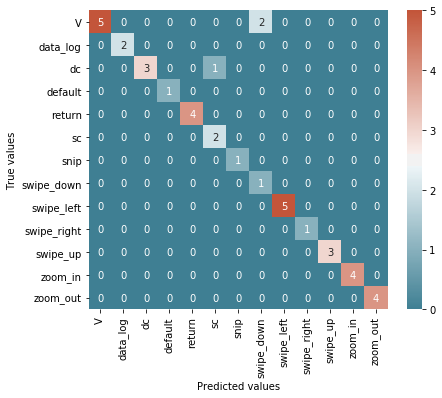

In [27]:
clf = train_clf_rf(X_train,y_train) # Train the classifier on a single train-test split

cf_matrix(clf, X_test, y_test) # Confusion Matrix
print('-' * 100)
clf_acc(clf, X_test, y_test) # Accuracy Score (single train-test split)
print('-' * 100)
cross_val(clf, X, y) # 10-fold-cross-valiadation score
print('-' * 100)

# 5. Summary
Here the whole Code is executed at once - for your comfort ;)

accuracy of the current Train_test-split 0.9487179487179487
RandomForestClassifier ---> Crossval score Accuracy:  0.98 (+/- 0.09)


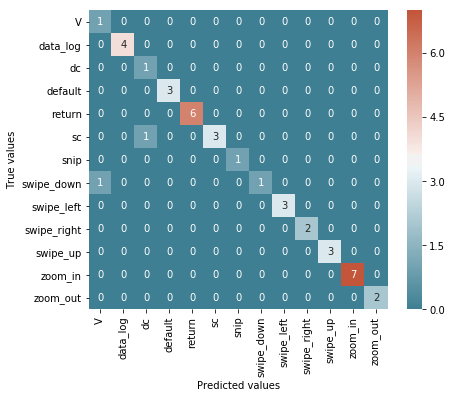

In [46]:
# 1. Get Data
path = os.getcwd() + '/data/' + 'User_1_3_121017' # -- change User_x_x_xxxxxx for different dataset
X_raw,y = get_datasets(path) # ----------------------- Function loads the data and the labels
frame_size = 140 # ----------------------------------- 1.4 seconds recording window

# split dataset into random Train and Test Data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.3) 

# 2. Preprocess Data
X_train = preprocess_raw_data(X_train_raw, frame_size)
X_test = preprocess_raw_data(X_test_raw , frame_size)

# 3,4 Machine Learning and Evaluation

# train classifier for single train-test split
trained_clf = train_clf_rf(X_train,y_train) # Train the classifier on a single train-test split
cf_matrix(trained_clf, X_test, y_test) # Confusion Matrix
clf_acc(trained_clf, X_test, y_test) # Accuracy Score (single train-test split)

# cross valiation score
clf_rf = RandomForestClassifier(bootstrap = True, max_depth = 30, max_features = 4, n_estimators = 250)
X = preprocess_raw_data(X_raw, frame_size) # Preprocess entire Dataset for the 10 fold cross validation score.
cross_val(clf_rf, X, y) # 10-fold-cross-valiadation score